# Analyse data distributions

This notebook is made to analyse the distribution of each explanatory variable regarding our tennis data samples

### imports

In [30]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="darkgrid", palette="deep")

### Get Data

In [31]:
path_to_data = "../data"
path_to_processed_data = os.path.join(path_to_data, "processed")
path_df = os.path.join(path_to_processed_data, "tennis_merged.csv") 

In [32]:
df = pd.read_csv(path_df)

### Visualize data

In [33]:
df.coupon_discount.unique()

array([ 0.,  5., 11., 10., 15.,  8.])

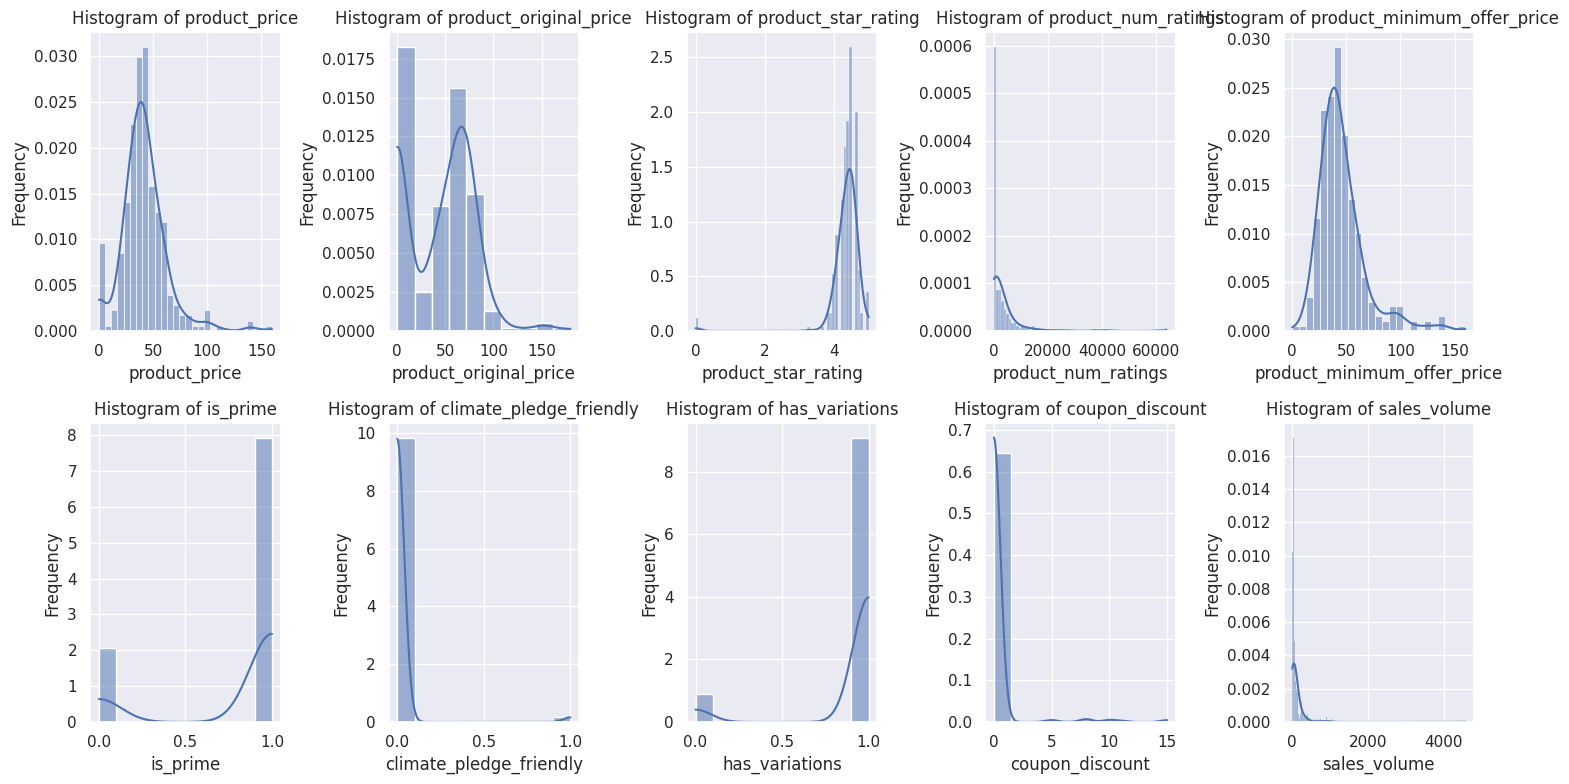

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # Tamaño ajustado para la cuadrícula
axes = axes.ravel()  # Convertimos los ejes a un array 1D para iterar fácilmente

# Iterar sobre las columnas y graficar los histogramas
for i, column in enumerate(df.select_dtypes(include='number').columns):
    #axes[i].hist(df[column], bins=30, color="b")
    sns.histplot(data=df, x=column, stat="density", ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Eliminar cualquier gráfico vacío (si hay más espacios que columnas)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Hypothesize distributions

In [35]:
hypothesized_distributions = {        
    'product_price': 'non-symmetric bimodal', 
    'product_original_price': 'symmetric bimodal', 
    'product_star_rating': 'normal',
    'product_num_ratings': 'exponential', 
    'product_minimum_offer_price': 'normal', 
    'is_prime': 'bernouilli',
    'climate_pledge_friendly': 'bernouilli', 
    'has_variations': 'bernouilli', 
    'coupon_discount': 'multinomial',
}

In [36]:
for variable, distribution in hypothesized_distributions.items():
    print("Hypothesis for the distribuion of {}: {}".format(variable, distribution))
    print("=" * 15)

Hypothesis for the distribuion of product_price: non-symmetric bimodal
Hypothesis for the distribuion of product_original_price: symmetric bimodal
Hypothesis for the distribuion of product_star_rating: normal
Hypothesis for the distribuion of product_num_ratings: exponential
Hypothesis for the distribuion of product_minimum_offer_price: normal
Hypothesis for the distribuion of is_prime: bernouilli
Hypothesis for the distribuion of climate_pledge_friendly: bernouilli
Hypothesis for the distribuion of has_variations: bernouilli
Hypothesis for the distribuion of coupon_discount: multinomial


## Godness-of-fit tests

In [37]:
from scipy import stats

In [38]:
hypotheses = pd.DataFrame(hypothesized_distributions.items(), columns=["variable_name", "distribution"])
hypotheses.sort_values(by="distribution", inplace=True)

In [39]:
hypotheses["result"] = None

In [40]:
hypotheses

,variable_name,distribution,result
5,is_prime,bernouilli,None
6,climate_pledge_friendly,bernouilli,None
7,has_variations,bernouilli,None
3,product_num_ratings,exponential,None
8,coupon_discount,multinomial,None
0,product_price,non-symmetric bimodal,None
2,product_star_rating,normal,None
4,product_minimum_offer_price,normal,None
1,product_original_price,symmetric bimodal,None


In [41]:
from statsmodels.stats.gof import gof_chisquare_discrete
from statsmodels.stats.diagnostic import kstest_fit, normal_ad  

### 1. Bimodal

In [42]:
# I found no library to measure the statistical significance for bimodal distributions 

### 2. Normal

In [43]:
help(normal_ad)

Help on function normal_ad in module statsmodels.stats._adnorm:

normal_ad(x, axis=0)
    Anderson-Darling test for normal distribution unknown mean and variance.
    
    Parameters
    ----------
    x : array_like
        The data array.
    axis : int
        The axis to perform the test along.
    
    Returns
    -------
    ad2 : float
        Anderson Darling test statistic.
    pval : float
        The pvalue for hypothesis that the data comes from a normal
        distribution with unknown mean and variance.
    
    See Also
    --------
    statsmodels.stats.diagnostic.anderson_statistic
        The Anderson-Darling a2 statistic.
    statsmodels.stats.diagnostic.kstest_fit
        Kolmogorov-Smirnov test with estimated parameters for Normal or
        Exponential distributions.



In [44]:
normal_ad(
    x=df["product_star_rating"].to_numpy(),
)

(31.27123351340947, 0.0)

In [45]:
hypotheses.loc[hypotheses["variable_name"]=="product_star_rating", "result"] = False

In [46]:
normal_ad(
    x=df["product_minimum_offer_price"].to_numpy(),
)

(11.731812461639777, 3.313806116552622e-28)

In [47]:
hypotheses.loc[hypotheses["variable_name"]=="product_minimum_offer_price", "result"] = False

### 3. Exponential

In [48]:
variable = "product_num_ratings"
data = df[variable].to_numpy()

In [49]:
# Perform Kolmogorov-Smirnov test

loc, scale = stats.expon.fit(data=data)
ks_statistic, p_value = stats.kstest(data, "expon", args=(loc, scale))

In [50]:
print("p-value: KS test for exponential distribution: {}".format(p_value))

p-value: KS test for exponential distribution: 2.767991937880161e-32


In [51]:
hypotheses.loc[hypotheses["variable_name"]==variable, "result"] = True

# Sample data: replace this with your actual data
plt.figure(figsize=(10, 6))
plt.title("Comparison: Sample vs Exponential Distribution")

# Histogram for sample data
plt.hist(data, bins=60, color='b', alpha=0.6, density=True, label='Sample Data Histogram')

# Histogram for exponential distribution with KDE
sns.histplot(data=exp_dist, stat="density", color='r', bins=60, kde=True, alpha=0.6, element='step', fill=False, label='Exponential Distribution Histogram')

plt.legend()
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


### 4. Bernouilli

In [52]:
prob_prime = df["is_prime"].mean()

In [53]:
gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(prob_prime,),
    rvs=df["is_prime"],
    alpha=0.05,
    msg="Is Prime "
)

(7.88860905221012e-31,
 0.9999999999999993,
 True,
 'chisquare - test for Is Prime at arg = (0.7935483870967742,) with pval = 0.9999999999999993')

In [54]:
hypotheses.loc[hypotheses["variable_name"]=="is_prime", "result"] = True

In [55]:
hypotheses

,variable_name,distribution,result
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,None
7,has_variations,bernouilli,None
3,product_num_ratings,exponential,True
8,coupon_discount,multinomial,None
0,product_price,non-symmetric bimodal,None
2,product_star_rating,normal,False
4,product_minimum_offer_price,normal,False
1,product_original_price,symmetric bimodal,None


In [56]:
# climate pledge

gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(df["climate_pledge_friendly"].mean(),),
    rvs=df["climate_pledge_friendly"].to_numpy(),
    alpha=0.05,    
    msg="Climate Pledge "
)

(3.9443045261050625e-30,
 0.9999999999999984,
 True,
 'chisquare - test for Climate Pledge at arg = (0.016129032258064516,) with pval = 0.9999999999999984')

In [57]:
hypotheses.loc[hypotheses["variable_name"]=="climate_pledge_friendly", "result"] = True

In [58]:
gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(df["has_variations"].to_numpy().mean(), ),
    rvs=df["has_variations"].to_numpy(),
    alpha=0.05,
    msg="Has variations"
)

(4.507776601262924e-31,
 0.9999999999999994,
 True,
 'chisquare - test for Has variationsat arg = (0.9096774193548387,) with pval = 0.9999999999999994')

In [59]:
hypotheses.loc[hypotheses["variable_name"]=="has_variations", "result"] = True

### 5. Multinomial

In [60]:
var_name = "coupon_discount"

In [61]:
import mmct

In [62]:
df.head()

,product_price,product_original_price,product_star_rating,product_num_ratings,product_minimum_offer_price,is_prime,climate_pledge_friendly,has_variations,coupon_discount,sales_volume
0,44.52,80.0,4.6,709,44.52,1.0,0.0,1.0,0.0,429
1,42.50,75.0,4.7,2028,42.50,1.0,0.0,1.0,0.0,117
2,38.50,70.0,4.5,502,38.50,1.0,0.0,1.0,0.0,185
3,30.69,50.0,4.5,40996,30.69,1.0,0.0,1.0,0.0,110
4,60.00,80.0,4.6,397,60.00,1.0,0.0,1.0,0.0,144


In [63]:
probs = df.groupby(by=var_name, axis=0).count().loc[:, "product_price"] / df.shape[0]

In [64]:
t = mmct.tester() # Use the multithreaded tester class
# Set number of Monte Carlo samples to generate
t.n_samples = df[var_name].size
x = np.array([ 0.,  5.,  8., 10., 11., 15.])
pval = t.do_test(x, probs)

In [65]:
pval

0.0

# Fitter for finding distributions

We tried to estimate the distribution of some explanatory variables. There are though no good fits for some of these variables. We propose to use fitter -a stats library- to find the best distribution for our data

In [69]:
pending_distributions = hypotheses[hypotheses["result"]!=True]

In [70]:
pending_distributions

,variable_name,distribution,result
8,coupon_discount,multinomial,None
0,product_price,non-symmetric bimodal,None
2,product_star_rating,normal,False
4,product_minimum_offer_price,normal,False
1,product_original_price,symmetric bimodal,None


In [67]:
from fitter import Fitter, get_common_distributions, get_distributions

### Fitter - Coupon Discount

In [72]:
distribution_fitter = Fitter(data=df["coupon_discount"].to_numpy())

In [73]:
distribution_fitter.fit()

2024-11-07 23:17:55.067 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-11-07 23:17:55.137 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=40.675676)
2024-11-07 23:17:55.253 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=38.228919)
2024-11-07 23:17:55.340 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=41.292657)
2024-11-07 23:17:55.353 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=41.633484)
2024-11-07 23:17:55.451 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=32.137149)
2024-11-07 23:17:55.451 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=30.950198)
2024-11-07 23:17:55.505 | INFO     | fitter.fitter:_fit_single_distribution:3

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
exponweib,7.389721,5922.597311,5937.543601,inf,0.967742,0.000000e+00
wald,9.477753,5385.726127,5393.199272,inf,0.800003,4.408886e-214
pearson3,12.436278,5812.925909,5824.135626,inf,0.967742,0.000000e+00
recipinvgauss,12.880919,5979.703926,5990.913643,inf,0.967742,0.000000e+00
exponnorm,19.101465,4674.126698,4685.336415,inf,0.966941,0.000000e+00


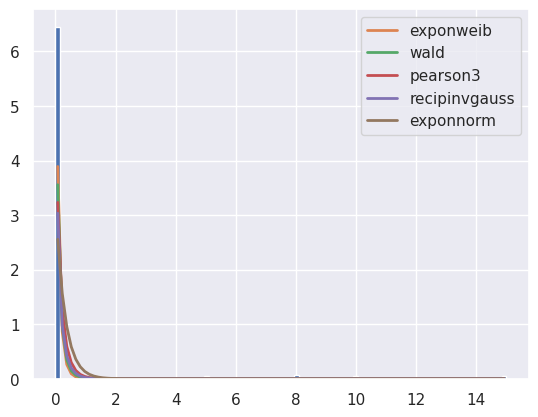

In [76]:
distribution_fitter.summary()

In [ ]:
distrib_fitter = Fitter(df["product_price"].to_numpy())
distrib_fitter.fit()

2024-11-07 23:22:11.447 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-11-07 23:22:11.981 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.065144)
2024-11-07 23:22:12.047 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.006984)
2024-11-07 23:22:12.429 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.003539)
2024-11-07 23:22:12.495 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted burr12 distribution with error=0.009465)
2024-11-07 23:22:12.575 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.011607)
2024-11-07 23:22:12.761 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.004236)
2024-11-07 23:22:12.896 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fi

/home/santi/current-projects/public-apis/amazon-mlops-dashboard/.venv/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
laplace,0.003270,1372.975307,1380.448452,inf,0.045989,0.513566
dgamma,0.003296,1365.460320,1376.670036,inf,0.043239,0.592725
johnsonsu,0.003310,1307.731488,1322.677777,inf,0.036933,0.777245
genhyperbolic,0.003310,1300.463630,1319.146492,inf,0.039049,0.716672
norminvgauss,0.003311,1298.573422,1313.519712,inf,0.039554,0.701855


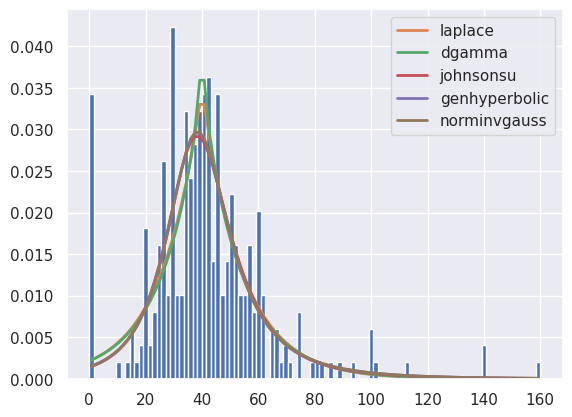

In [78]:
distrib_fitter.summary()

In [79]:
distribution_fitter = Fitter(df["product_star_rating"].to_numpy())
distribution_fitter.fit()

/home/santi/current-projects/public-apis/amazon-mlops-dashboard/.venv/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
2024-11-07 23:25:09.069 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-11-07 23:25:09.588 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=47.599509)
2024-11-07 23:25:09.595 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=31.354036)
2024-11-07 23:25:10.035 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=27.989142)
2024-11-07 23:25:10.285 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted burr12 distribution with error=28.088858)
2024-11-07 23:25:10.394 | INFO     | fitter.fitter:

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
johnsonsu,24.930850,968.563903,983.510192,inf,0.118095,0.000318
burr,24.957776,1315.901404,1330.847693,inf,0.108307,0.001273
skewcauchy,25.281364,709.001918,720.211635,inf,0.124897,0.000113
norminvgauss,25.284171,907.635416,922.581705,inf,0.121559,0.000189
laplace_asymmetric,25.427639,1321.901376,1333.111093,inf,0.132827,0.000031


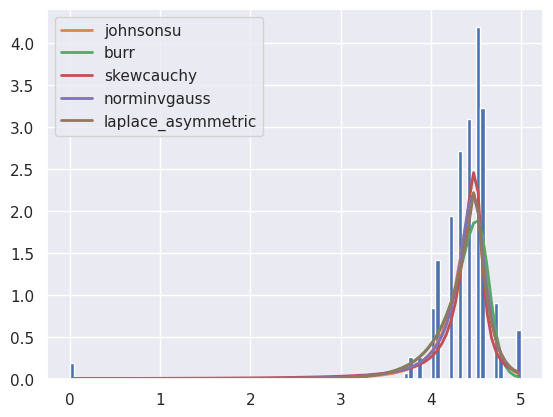

In [80]:
distribution_fitter.summary()

In [82]:
pending_distributions

,variable_name,distribution,result
8,coupon_discount,multinomial,None
0,product_price,non-symmetric bimodal,None
2,product_star_rating,normal,False
4,product_minimum_offer_price,normal,False
1,product_original_price,symmetric bimodal,None


In [87]:
dist_fitter = Fitter(data=df["product_minimum_offer_price"].to_numpy())

In [88]:
dist_fitter.fit()

2024-11-07 23:29:50.256 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.008686)
2024-11-07 23:29:50.272 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-11-07 23:29:50.276 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=0.008817)
2024-11-07 23:29:50.316 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.083427)
2024-11-07 23:29:50.374 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.010242)
2024-11-07 23:29:50.425 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=0.002961)
2024-11-07 23:29:50.437 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.012258)
2024-11-07 23:29:50.464 | INFO     | fitter.fitter:_fit_single_distribution:333 - F

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
laplace,0.003270,1372.975307,1380.448452,inf,0.045989,0.513566
dgamma,0.003296,1365.460320,1376.670036,inf,0.043239,0.592725
johnsonsu,0.003310,1307.731488,1322.677777,inf,0.036933,0.777245
genhyperbolic,0.003310,1300.463630,1319.146492,inf,0.039049,0.716672
norminvgauss,0.003311,1298.573422,1313.519712,inf,0.039554,0.701855


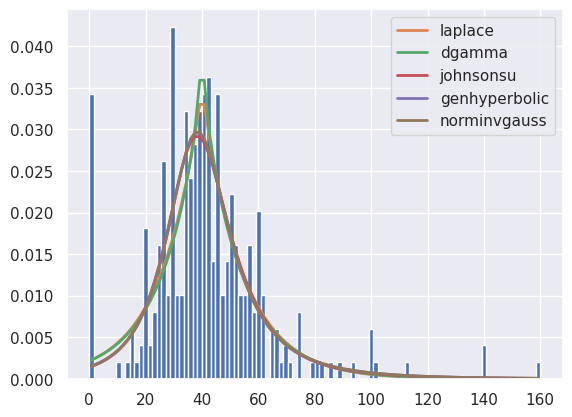

In [89]:
distrib_fitter.summary()

In [90]:
dist_fitter.get_best(method="ks_pvalue")

{'foldnorm': {'c': 1.2897477503126645e-08,
  'loc': 10.989999946778031,
  'scale': 5.586166348855215}}

In [104]:
# Save the results

distributions = []

for random_variable in df.columns.drop("sales_volume"):
    f = Fitter(data=df[random_variable].to_numpy())
    f.fit()
    best_dist = f.get_best(method="ks_pvalue")
    best_dist.update({"random_variable": random_variable})
    distributions.append(best_dist)
    del f

2024-11-07 23:50:09.608 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.065144)
2024-11-07 23:50:09.821 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.006984)
2024-11-07 23:50:10.110 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.011607)
2024-11-07 23:50:10.556 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-11-07 23:50:10.803 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted betaprime distribution with error=0.005861)
2024-11-07 23:50:10.871 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=0.009003)
2024-11-07 23:50:11.028 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.010885)
2024-11-07 23:50:11.618 | INFO     | fitter.fitter:_fit_single_distribution:33

/home/santi/current-projects/public-apis/amazon-mlops-dashboard/.venv/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/santi/current-projects/public-apis/amazon-mlops-dashboard/.venv/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/santi/current-projects/public-apis/amazon-m

In [111]:
import json

with open("./distributions.json", "w") as fp:
    json.dump(distributions, fp=fp)